In [2]:
!git clone https://github.com/SonaliDasgupta/goodbooks-10k

Cloning into 'goodbooks-10k'...
remote: Enumerating objects: 66, done.
remote: Total 66 (delta 0), reused 0 (delta 0), pack-reused 66
Unpacking objects: 100% (66/66), done.
Checking out files: 100% (20/20), done.


In [0]:
import pandas as pd


In [4]:
!pip install fastai pytorch

    100% |████████████████████████████████| 153kB 10.4MB/s 
    100% |████████████████████████████████| 1.9MB 14.6MB/s 
    100% |████████████████████████████████| 591.8MB 25kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x625ca000 @  0x7f07191942a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 23.3MB 1.5MB/s 
    100% |████████████████████████████████| 61kB 22.0MB/s 
    100% |████████████████████████████████| 112kB 21.8MB/s 
  Running setup.py bdist_wheel for pytorch ... - error
  Complete output from command /usr/bin/python3 -u -c "import setuptools, tokenize;__file__='/tmp/pip-install-7pytvqba/pytorch/setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(cod

In [0]:
ratings_df = pd.read_csv('goodbooks-10k/ratings.csv')

from fastai.collab import CollabDataBunch
from fastai.collab import collab_learner


In [0]:
import torch.optim as optim
from fastai.metrics import exp_rmspe
data = CollabDataBunch.from_df(ratings_df) #no test dataset here
wd = 1e-3
m = collab_learner(data, n_factors = 50, y_range = (1,5), metrics = [exp_rmspe])
#m.opt_fn = optim.Adam(params = m.parameters, lr = 0.5)
#choosing 50 factors as of now, might try with half the size of dataset later
#ratings go from 1 to 5 hence y_range

In [7]:
from fastai.train import lr_find
lr_find(m)
m.recorder.plot_metrics

epoch,train_loss,valid_loss,exp_rmspe


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


<bound method Recorder.plot_metrics of Recorder(learn=CollabLearner(data=TabularDataBunch;

Train: LabelList
y: FloatList (4781184 items)
[FloatItem 5.0, FloatItem 5.0, FloatItem 3.0, FloatItem 5.0, FloatItem 5.0]...
Path: .
x: CollabList (4781184 items)
[CollabLine user_id 1; book_id 258; , CollabLine user_id 2; book_id 260; , CollabLine user_id 2; book_id 315; , CollabLine user_id 2; book_id 301; , CollabLine user_id 2; book_id 2686; ]...
Path: .;

Valid: LabelList
y: FloatList (1195295 items)
[FloatItem 4.0, FloatItem 5.0, FloatItem 2.0, FloatItem 3.0, FloatItem 5.0]...
Path: .
x: CollabList (1195295 items)
[CollabLine user_id 6849; book_id 20; , CollabLine user_id 21888; book_id 1704; , CollabLine user_id 1383; book_id 1627; , CollabLine user_id 33213; book_id 1441; , CollabLine user_id 32573; book_id 420; ]...
Path: .;

Test: None, model=EmbeddingDotBias(
  (u_weight): Embedding(53425, 50)
  (i_weight): Embedding(10001, 50)
  (u_bias): Embedding(53425, 1)
  (i_bias): Embedding(100

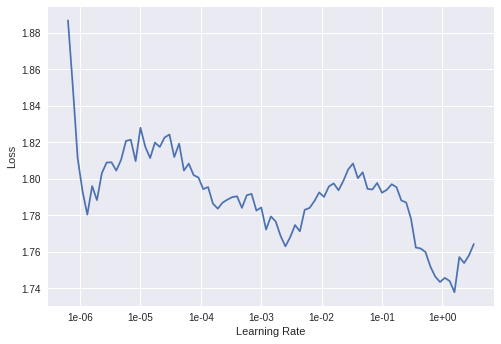

In [8]:
m.recorder.plot()

In [0]:
m.opt = optim.Adam(params = m.model.parameters(), lr = 0.03)
m.opt.mom = 0.9
m.fit(3, lr = 0.03, wd = 1e-5) #PULL CODE IN SPYDER  AND SEE OPTIM WRAPPER USAGE , TRY WITH ADAM LATER AND ALSO WEIGHT DECAY AND MOMENTUM
#TRY WITH BOTH ADAM AND SGD

epoch,train_loss,valid_loss,exp_rmspe


In [0]:
#with SGD optimization
m1 = collab_learner(data, n_factors = 50, y_range = (1,5), metrics = [exp_rmspe])
m1.opt = optim.SGD(params = m1.model.parameters(), lr = 0.5, momentum = 0.9)
m1.opt.mom = 0.9
m1.fit(3, lr = 0.03)

#SGD performs way better
#TRY ONCE WITH SAME WEiGHT DECAY

In [0]:
#1.  interpret embeddings
#2. Create columnar model using the metatdata, and compare the 2 models on a metric
#3 scrape the web data from good reads website

In [0]:
m1.model.i_weight #analyzing movie categories
#from sklearn.decomposition import PCA


In [0]:
#perform inner join with books
books_df = pd.read_csv('goodbooks-10k/books.csv')


In [0]:
books_df.columns

In [0]:
ratings_df.columns


In [0]:
ratings_book_df = ratings_df.merge(books_df, how = 'left', on = 'book_id')

In [0]:
cols = [col for col in ratings_book_df.columns if col not in ratings_df.columns and col not in ['book_id','title', 'authors', 'language_code']]
ratings_book_df.drop(cols, axis= 1, inplace = True)

In [0]:
count_ratings = ratings_book_df.groupby('book_id')['rating'].count()


In [0]:
count_ratings

In [0]:
top300books = count_ratings.sort_values(ascending = False).index.values[:300]
top300books.dtype

In [0]:
books_df['book_id'].dtype

In [0]:

bias_books = m1.bias([str(book) for book in top300books])
bias_books.shape

In [0]:
book_names = {}
for book in top300books:
  book_names[book] = books_df.iloc[book, 10]

In [0]:
names_with_bias = pd.DataFrame({'bookName': book_names.values(), 'bias': bias_books}, columns=['bookName', 'bias'])
books_avg_bias = names_with_bias.groupby(['bookName']).agg({'bias': 'sum'})

In [0]:
books_avg_bias

In [0]:
data.classes